### Imports 

In [1]:
# Data Management
import numpy as np
import pandas as pd
import polars as pl  # Using Polars for data management

# Data Preprocessing
from sklearn.preprocessing import StandardScaler

# Unsupervised Machine Learning
from sklearn.decomposition import PCA

# Deep Learning
import torch
from torch.utils.data import Dataset, DataLoader

# Visualization
import matplotlib.pyplot as plt

### Data Extraction and Feature Engineering

In [2]:
# Load data from saved file using Polars
df = pl.read_csv("data/pair_trade.csv")
df = df.drop("Date")  # Reassign to df to update it after dropping the 'Date' column
df.head(2)
print(f"Length: {len(df)}")

Length: 1264


In [4]:

# Calculate logarithmic returns in steps to avoid referencing errors
# First, calculate the log of current and shifted values
df = df.with_columns([
    pl.col("Asset1").log().alias("log_a1"),
    pl.col("Asset2").log().alias("log_a2"),
    pl.col("Asset1").shift(1).log().alias("log_prev_a1"),
    pl.col("Asset2").shift(1).log().alias("log_prev_a2")
])

# Then, calculate the log returns
df = df.with_columns([
    (pl.col("log_a1") - pl.col("log_prev_a1")).alias("lrets_a1"),
    (pl.col("log_a2") - pl.col("log_prev_a2")).alias("lrets_a2")
]).drop(["log_a1", "log_a2", "log_prev_a1", "log_prev_a2"])

# Calculate rolling means for the log returns (21-day moving average)
df = df.with_columns([
    pl.col("lrets_a1").rolling_mean(window_size=21).alias("lrets_a1_roll"),
    pl.col("lrets_a2").rolling_mean(window_size=21).alias("lrets_a2_roll")
])

# Calculate cumulative returns
df = df.with_columns([
    pl.col("lrets_a1").cum_sum().alias("a1_prod_rets"),
    pl.col("lrets_a2").cum_sum().alias("a2_prod_rets")
])

# Drop rows with any NA values (equivalent to dropna() in pandas)
df = df.drop_nulls()

# Output the length of the DataFrame and the first two rows to verify
print("Length: ", df.height)
print(df.head(2))


Length:  1243
shape: (2, 10)
┌───────────┬───────────┬───────────┬──────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ Asset1    ┆ Asset2    ┆ Spread    ┆ ZScore   ┆ … ┆ lrets_a1_ ┆ lrets_a2_ ┆ a1_prod_r ┆ a2_prod_r │
│ ---       ┆ ---       ┆ ---       ┆ ---      ┆   ┆ roll      ┆ roll      ┆ ets       ┆ ets       │
│ f64       ┆ f64       ┆ f64       ┆ f64      ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│           ┆           ┆           ┆          ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞═══════════╪═══════════╪═══════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 54.227489 ┆ 53.271168 ┆ -2.055377 ┆ 0.403727 ┆ … ┆ 0.000527  ┆ 0.000836  ┆ 0.011074  ┆ 0.017551  │
│ 53.589405 ┆ 52.501556 ┆ -1.88034  ┆ 0.649103 ┆ … ┆ -0.000028 ┆ 0.000188  ┆ -0.000763 ┆ 0.002998  │
└───────────┴───────────┴───────────┴──────────┴───┴───────────┴───────────┴───────────┴───────────┘


In [5]:
df.columns

['Asset1',
 'Asset2',
 'Spread',
 'ZScore',
 'lrets_a1',
 'lrets_a2',
 'lrets_a1_roll',
 'lrets_a2_roll',
 'a1_prod_rets',
 'a2_prod_rets']

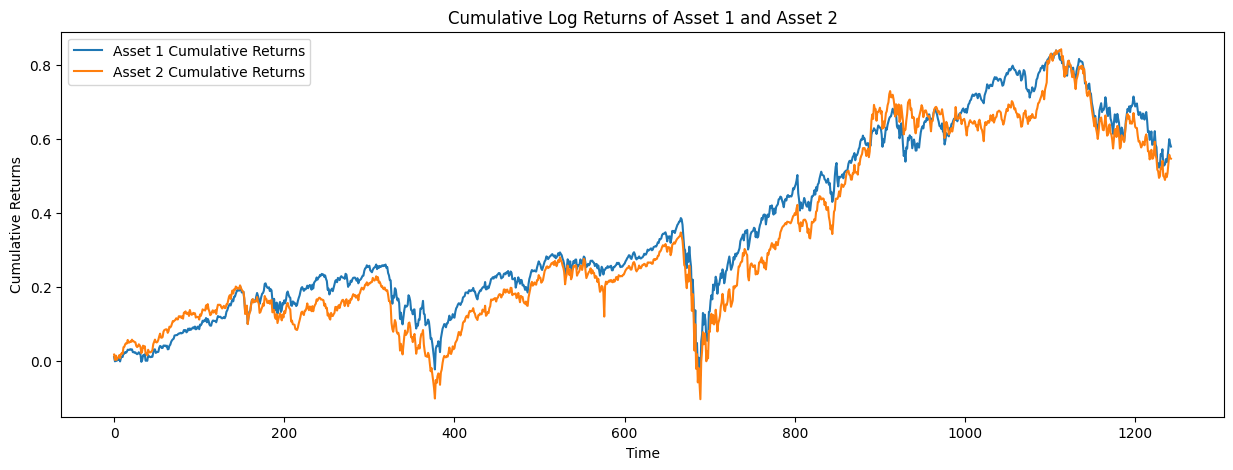

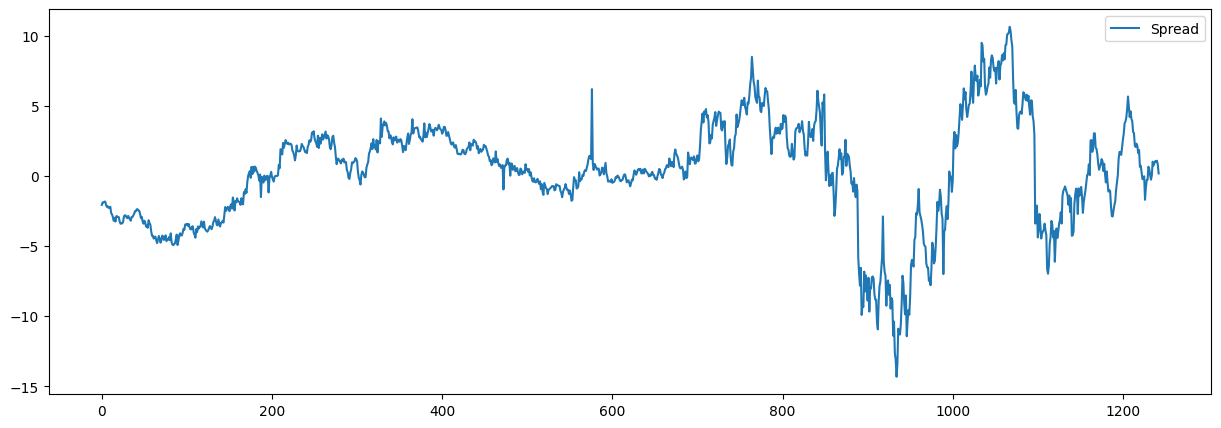

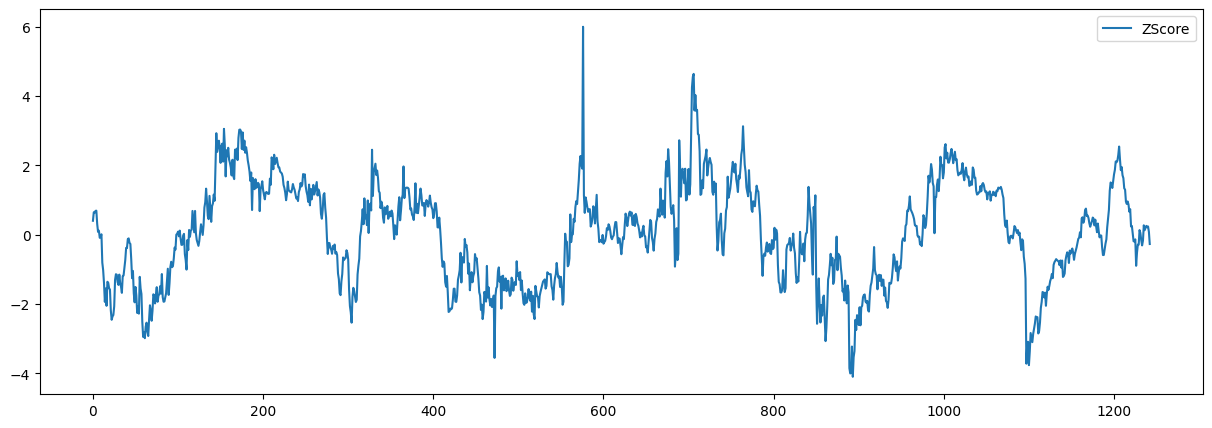

In [10]:
# Visualize Data
fig, ax = plt.subplots(figsize=(15, 5))  # Set the figure size for better visibility
ax.plot(df['a1_prod_rets'].to_numpy(), label='Asset 1 Cumulative Returns')  # Convert to numpy array for Matplotlib
ax.plot(df['a2_prod_rets'].to_numpy(), label='Asset 2 Cumulative Returns')  # Convert to numpy array for Matplotlib
ax.set_title('Cumulative Log Returns of Asset 1 and Asset 2')  # Adding a title for clarity
ax.set_xlabel('Time')  # Label for the x-axis
ax.set_ylabel('Cumulative Returns')  # Label for the y-axis
ax.legend()  # Add a legend to clarify which line corresponds to which asset
plt.show()  # Display the plot

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df['Spread'].to_numpy(), label='Spread')
ax.legend()
plt.show()

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(df['ZScore'].to_numpy(), label='ZScore')
ax.legend()
plt.show()

![Z-Score Image](data/zscore.jpeg)


### Z-Score: Statistical Definition

A **Z-Score** is a statistical measure that quantifies the relationship of a value to the **mean** of a group of values. It is measured in terms of **standard deviations** from the mean. 

#### Formula
The formula to calculate the Z-Score of a value \( x \) is given by:

\[
Z = \frac{(X - \mu)}{\sigma}
\]

where:
- \( X \) is a specific value from the dataset.
- \( \mu \) (mu) represents the mean of the dataset.
- \( \sigma \) (sigma) is the standard deviation of the dataset.

#### Example

Consider a dataset of test scores with a mean (\( \mu \)) of 70 and a standard deviation (\( \sigma \)) of 10. If a student scores 90, the Z-Score would be:

\[
Z = \frac{(90 - 70)}{10} = 2
\]

This Z-Score tells us that the student's score is 2 standard deviations above the mean score of the dataset.


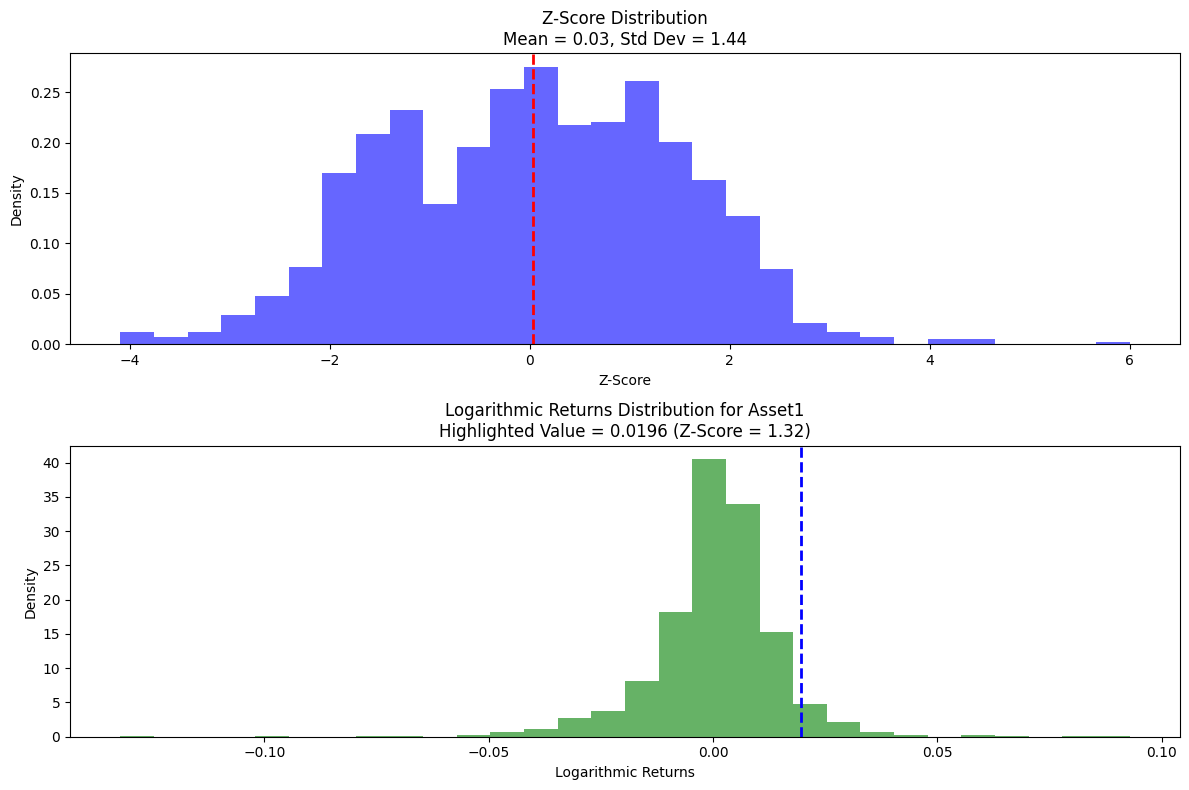

In [13]:
import matplotlib.pyplot as plt
import polars as pl

# Assuming 'df' is your Polars DataFrame

# Extract the 'ZScore' column data for plotting
z_scores = df['ZScore'].to_numpy()

# Extract the 'lrets_a1' column data for plotting
log_returns_a1 = df['lrets_a1'].to_numpy()

# Calculate the mean and standard deviation of Z-Scores
mean_z = df['ZScore'].mean()
std_dev_z = df['ZScore'].std()

# Calculate the Z-Score for an example value in 'lrets_a1', say the 95th percentile value
example_value = df['lrets_a1'].quantile(0.95)
z_example = (example_value - df['lrets_a1'].mean()) / df['lrets_a1'].std()

# Plotting
plt.figure(figsize=(12, 8))

# Plot Z-Score distribution
plt.subplot(2, 1, 1)  # 2 rows, 1 column, first subplot
plt.hist(z_scores, bins=30, density=True, alpha=0.6, color='b')
plt.axvline(mean_z, color='red', linestyle='dashed', linewidth=2)
plt.title(f"Z-Score Distribution\nMean = {mean_z:.2f}, Std Dev = {std_dev_z:.2f}")
plt.xlabel('Z-Score')
plt.ylabel('Density')

# Plot Logarithmic Returns distribution for Asset1
plt.subplot(2, 1, 2)  # 2 rows, 1 column, second subplot
plt.hist(log_returns_a1, bins=30, density=True, alpha=0.6, color='g')
plt.axvline(example_value, color='blue', linestyle='dashed', linewidth=2)
plt.title(f"Logarithmic Returns Distribution for Asset1\nHighlighted Value = {example_value:.4f} (Z-Score = {z_example:.2f})")
plt.xlabel('Logarithmic Returns')
plt.ylabel('Density')

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


In [16]:
# Add Target
future_step = 1

# Create the 'TARGET' column based on the condition of 'Spread' shifted by -1
df = df.with_columns(
    (df["Spread"].shift(-future_step) > 0).cast(pl.UInt8).alias("TARGET")
)

# Drop rows with any missing values
df = df.drop_nulls()

# Display the first two rows
df.head()

# df = df.with_column(
#     (df["Spread"].shift(-future_step) > 0)  # Step 1: Shift the 'Spread' column upward by 'future_step' (1 row in this case)
#                                             # and compare each value to see if it's greater than 0.
#     .cast(pl.UInt8)                         # Step 2: Convert the resulting boolean values (True/False) from the comparison
#                                             # into unsigned 8-bit integers (1 for True, 0 for False). This is similar to casting
#                                             # to integer in other programming contexts but specifies the bit-length to optimize memory.
#     .alias("TARGET")                        # Step 3: Name the new column 'TARGET'. The 'alias' method is used to rename the column
#                                             # result from the previous operations.
# )


Asset1,Asset2,Spread,ZScore,lrets_a1,lrets_a2,lrets_a1_roll,lrets_a2_roll,a1_prod_rets,a2_prod_rets,TARGET
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,u8
54.227489,53.271168,-2.055377,0.403727,-0.000543,0.000741,0.000527,0.000836,0.011074,0.017551,0
53.589405,52.501556,-1.88034,0.649103,-0.011837,-0.014552,-0.000028,0.000188,-0.000763,0.002998,0
54.256935,53.13303,-1.879984,0.634294,0.012379,0.011956,0.00064,0.000793,0.011617,0.014954,0
53.658115,52.521286,-1.832474,0.689018,-0.011098,-0.01158,0.000077,0.000134,0.000519,0.003374,0
53.932976,52.76796,-1.818233,0.694927,0.005109,0.004686,-0.000113,-0.00008,0.005628,0.008059,0
…,…,…,…,…,…,…,…,…,…,…
55.788349,55.787228,-3.152823,-1.214442,-0.001407,-0.010381,0.001136,0.001047,0.039451,0.0637,0
55.552742,55.747749,-3.34672,-1.55197,-0.004232,-0.000708,0.00096,0.001255,0.035219,0.062992,0
55.572369,55.866154,-3.452192,-1.708105,0.000353,0.002122,0.000806,0.001192,0.035572,0.065114,0


In [19]:

# Split X and y
X_data = df.drop("TARGET")  # Drops the 'TARGET' column to create the feature set
y = df.select("TARGET")     # Selects only the 'TARGET' column for the target variable

# Length of X_data and y (length checks)
len_X_data = X_data.height  # Uses .height to get the number of rows in the Polars DataFrame
len_y = y.height            # Same as above

len_X_data, len_y


(1241, 1241)

In [20]:
# Convert to numpy array
X_data = X_data.to_numpy()  # need to convert since it is a polars df
y = y.to_numpy().flatten()  # Flatten is used because the target is likely a single column and you need a 1D array

In [23]:
from sklearn.preprocessing import StandardScaler

# Feature Scaling
# Feature scaling is essential for many machine learning algorithms because it standardizes 
# the range of the features of data. This means adjusting for the fact that different features 
# may operate on different scales, and algorithms that compute distances between data points, 
# like k-means clustering or k-nearest neighbors, can be biased towards features with larger scales.

scaler = StandardScaler()  # Create an instance of StandardScaler. This scaler removes the mean and scales 
                            # the data to unit variance, which helps in normalizing the distribution of feature values.

X = scaler.fit_transform(X_data)  # Fit to data, then transform it. 'fit' computes the mean and std to be used 
                                   # for later scaling (just fitting the data), and 'transform' actually scales 
                                   # the data using the computed mean and std.

X[:2]  # Display the first two records of the transformed data to verify the scaling. This can be useful to 
       # inspect the outcome and ensure that the scaling is applied correctly.


array([[-1.26327564, -1.13342369, -0.63336595,  0.25856065, -0.06986802,
         0.01916231,  0.02731413,  0.13087065, -1.46509426, -1.28578843],
       [-1.29552617, -1.17413052, -0.5862704 ,  0.42919493, -0.84615003,
        -0.94001663, -0.15744022, -0.0700035 , -1.51468108, -1.346482  ]])

### Build Neural Net

### Train Neural Net